## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [24]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[32, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [25]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [36]:
# 載入 Callbacks
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix

# Record_fp_tp
class Record_tp_tn(Callback):
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0]).argmax(axis = 1)
        print(y_true, y_pred)
#         y_pred = (y_pred[:, 1] >= thres) * 1
        cm = confusion_matrix(y_true, y_pred)
        
        for i in range(10):
            logs['val_tp_%d' % (i)] = cm[i][i] / sum(cm[i])
            logs['val_tn_%d' % (i)] = (len(y_true) - sum(cm[i]) - sum(cm[:, i]) + cm[i][i]) / len(y_true)
                        
        
rec_tptn = Record_tp_tn()

In [37]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

"""Code Here
將 callbacks 放入模型訓練流程中
"""
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[rec_tptn]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 32)                98336     
_________________________________________________________________
batch_normalization_19 (Batc (None, 32)                128       
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               8448      
_________________________________________________________________
batch_normalization_20 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_21 (Batc (None, 128)               512       
__________

In [18]:
model.history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'val_tp_0', 'val_tn_0', 'val_tp_1', 'val_tn_1', 'val_tp_2', 'val_tn_2', 'val_tp_3', 'val_tn_3', 'val_tp_4', 'val_tn_4', 'val_tp_5', 'val_tn_5', 'val_tp_6', 'val_tn_6', 'val_tp_7', 'val_tn_7', 'val_tp_8', 'val_tn_8', 'val_tp_9', 'val_tn_9'])

In [34]:
print(model.history.history['val_tn_9'])

[0.8474, 0.841, 0.8301, 0.8158, 0.8156, 0.8067, 0.8217, 0.824, 0.8313, 0.8419, 0.832, 0.8426, 0.8336, 0.8288, 0.8339, 0.8408, 0.848, 0.8411, 0.8486, 0.8576, 0.8474, 0.8421, 0.8281, 0.8518, 0.853]


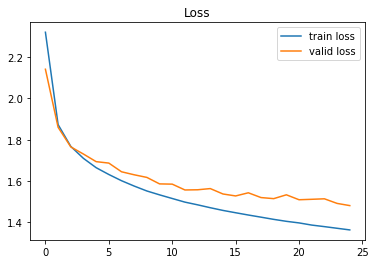

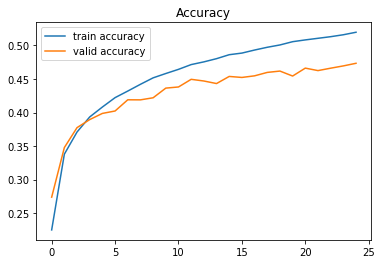

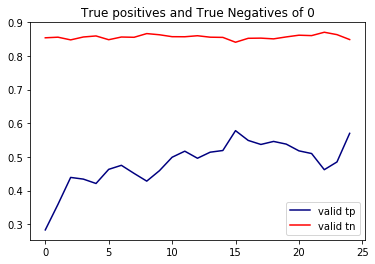

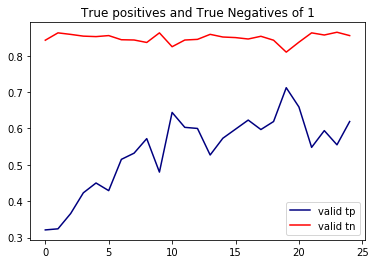

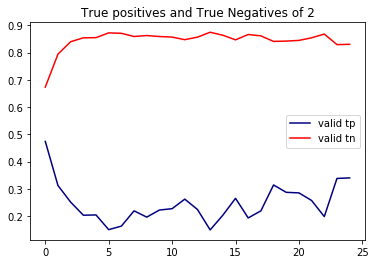

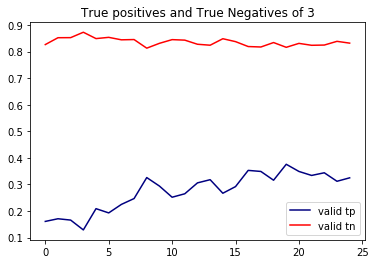

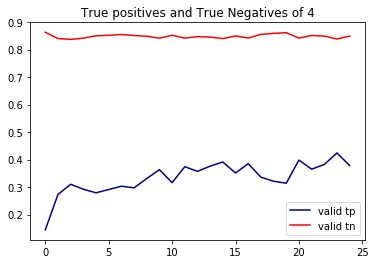

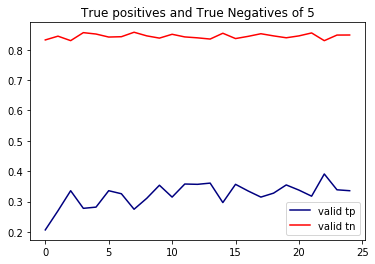

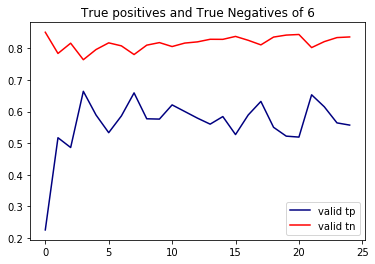

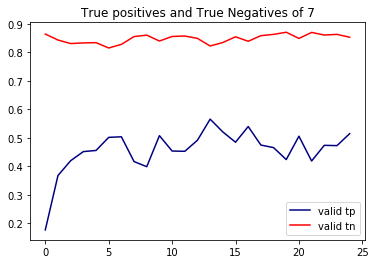

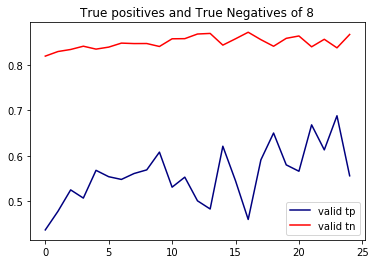

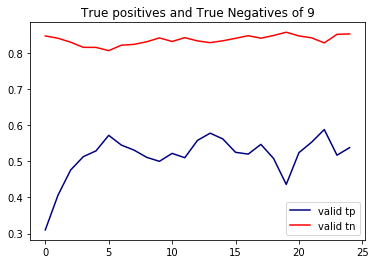

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

for i in range(10):
    plt.plot(range(len(model.history.history["val_tp_%d" % (i)])), model.history.history["val_tp_%d" % (i)], label="valid tp", color="navy")
    plt.plot(range(len(model.history.history["val_tn_%d" % (i)])), model.history.history["val_tn_%d" % (i)], label="valid tn", color="red")
    plt.legend()
    plt.title("True positives and True Negatives of %d" %(i))
    plt.show()
